In [17]:
import numpy as np
from scipy.optimize import linprog

# Linear Program for fractional clique number

Define a function to return all possible subsests for list of vertices V

In [2]:
def subsets(V, prefix=[], arr_sets=[]):
    if V == []: return
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets += [subset]
        subsets(V[i+1:], subset, arr_sets)

In [3]:
def check_clique(graph, v_set):
    if len(v_set) < 2: return True
    for i in range(len(v_set)):
        i_set = set(v_set[:i] + v_set[i+1:])
        g_set = graph[v_set[i]]
        if i_set & g_set != i_set :
            return False
    return True

In [4]:
def A_clique_set(graph, v_encode, subsets, A=[]):
    for subset in subsets:
        if check_clique(graph, subset):
            A += [sum([v_encode[v] for v in subset])]

In [5]:
def lp_clique(graph):
    V = list(graph.keys())
    v_encode = {}
    v_num = len(V)
    
    for i in range(v_num):
        temp = np.zeros(v_num)
        temp[i] = -1
        v_encode[V[i]] = temp
    
    arr_sets = []
    subsets(V, arr_sets=arr_sets)
    
    b_clique = np.negative(np.ones(v_num))
    A_clique = []
    A_clique_set(graph, v_encode, arr_sets,A=A_clique)
    A_clique = np.transpose(np.array(A_clique))
    c_clique = np.ones(A_clique.shape[1])
    
    res = linprog(c_clique, A_ub=A_clique, b_ub=b_clique, bounds=(0, None))
    return res, A_clique

# Linear Program for Shannon entropy

In [50]:
def removed_unconnected_v(graph):
    keys = list(graph.keys())
    for v in keys:
        if len(graph[v]) == 0:
            graph.pop(v, None)

In [53]:
G10 = {1:set({}), 2:set({}), 3:set({}), 4:set({}), 5:set({}), 6:set({})}

In [55]:
removed_unconnected_v(G10)

In [56]:
G10

{}

In [19]:
def subsets_dict(V, prefix=[], arr_sets={}):
    if V == []: return 1
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets[tuple(subset)] = len(arr_sets)
        subsets_dict(V[i+1:], subset, arr_sets)

In [20]:
def A_entropy_set(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    for subset in subsets_dict:
        subset_len = len(subset)
        subset_i = subsets_dict[subset]
        a_lq = np.zeros(num_sets)
        if subset_len > 1:
            a_lq[subset_i] = -1 * (subset_len)
            a_mq = np.zeros(num_sets)
            a_mq[subset_i] = subset_len - 1
            s = set(subset)
            for v in subset:
                sub_i = subsets_dict[tuple(x for x in subset if v != x)]
                a_lq[sub_i] = 1    
                a_mq[sub_i] = -1
            A += [a_lq, a_mq]
            b += [0, 0]
        else:
            a_lq[subset_i] = 1
            A += [a_lq]
            b += [1]

In [21]:
def A_entropy_set_2(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        for j in range(i, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            a_lq = np.zeros(num_sets)
            if len(subset_i) < 2 and pos_i == pos_j: 
                a_lq[pos_i] = 1
                A += [a_lq]
                b += [1]
#                 print("identical", subset_i)
            else:
                a_mq = np.zeros(num_sets)
                subset_i = set(subset_i)
                subset_j = set(subset_j)
                subset_ij_u = subset_i | subset_j
                subset_ij_i = subset_i & subset_j
                if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                    if len(subset_i) > len(subset_j):
                        a_mq[pos_i] = -1
                        a_mq[pos_j] = 1
                        A += [a_mq]
                        b += [0]
                    elif len(subset_i) < len(subset_j):
                        a_mq[pos_i] = 1
                        a_mq[pos_j] = -1
                        A += [a_mq]
                        b += [0]
#                     print("intersect each other", subset_i, subset_j)
                else:
#                     print("not intersection of each other", subset_i, subset_j)
                    a_lq[pos_i] = -1
                    a_lq[pos_j] = -1
                    a_lq[subsets_dict[tuple(subset_ij_u)]] = 1
                    if len(subset_ij_i) > 0:
                        a_lq[subsets_dict[tuple(subset_ij_i)]] = 1
                    A += [a_lq]
                    b += [0]

This version is missing a lot of important conditions

In [22]:
def A_entropy_set_3(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        for j in range(i, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            a_mq = np.zeros(num_sets)
            if len(subset_i) < 2 and pos_i == pos_j: 
                a_mq[pos_i] = 1
                A += [a_mq]
                b += [1]
            else:
                subset_i = set(subset_i)
                subset_j = set(subset_j)
                subset_ij_u = subset_i | subset_j
                subset_ij_i = subset_i & subset_j
                if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                    if len(subset_i) > len(subset_j):
                        a_mq[pos_i] = -1
                        a_mq[pos_j] = 1
                        A += [a_mq]
                        b += [0]
                    elif len(subset_i) < len(subset_j):
                        a_mq[pos_i] = 1
                        a_mq[pos_j] = -1
                        A += [a_mq]
                        b += [0]
        
        if len(subset_i) > 1:
            a_lq = np.zeros(num_sets)
            a_lq[pos_i] = 1
            for v in subset_i:
                sub_i = subsets_dict[(v,)]
                a_lq[sub_i] = -1
            A += [a_lq]
            b += [0]


In [23]:
def entropy_eq_dict(graph, eq_dicts = {}, subsets):
    subsets.sort(key=len)
    for v in graph:
        n = tuple(graph[v])
        n_v = tuple(graph[v] | {v})
        eq_dicts[n] += [n_v]
    
     
    

In [24]:
def A_entropy_set_4(graph, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict)
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        for j in range(i, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            a_mq = np.zeros(num_sets)
            if len(subset_i) < 2 and pos_i == pos_j: 
                a_mq[pos_i] = 1
                A += [a_mq]
                b += [1]
            else:
                rep_i = ()
                if subset_i in eq_dict: 
                    rep_i = 
                    
                subset_i = set(subset_i)
                subset_j = set(subset_j)
                subset_ij_u = subset_i | subset_j
                subset_ij_i = subset_i & subset_j
                
                if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                    diff = len(subset_i) - len(subset_j)
                    if diff == 1:
                        a_mq[pos_i] = -1
                        a_mq[pos_j] = 1
                        A += [a_mq]
                        b += [0]
                    elif diff == -1:
                        a_mq[pos_i] = 1
                        a_mq[pos_j] = -1
                        A += [a_mq]
                        b += [0]
                    



SyntaxError: invalid syntax (<ipython-input-24-42fe81a0d207>, line 20)

In [25]:
def A_entropy_eq_set(graph, subsets_dict, A=[]):
    num_sets = len(subsets_dict)
    for v in graph:
        n = tuple(graph[v])
        n_v = tuple(graph[v] | {v})
        a_eq = np.zeros(num_sets)
        a_eq[subsets_dict[n_v]] = 1
        if len(n) > 0: 
            a_eq[subsets_dict[n]] = -1
        A += [a_eq]

In [109]:
def lp_entropy(graph):
    # remove all isolated vertices from the graph
    removed_unconnected_v(graph)
        
    V = list(graph.keys())
    v_encode = {}
    v_num = len(V)
    
    if v_num == 0: return 0
    
    for i in range(v_num):
        temp = np.zeros(v_num)
        temp[i] = -1
        v_encode[V[i]] = temp
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    A_entropy = []
    b_entropy = []
    A_entropy_set_2(V, arr_sets, A=A_entropy, b=b_entropy)
    A_entropy = np.array(A_entropy)
    b_entropy = np.array(b_entropy, dtype=float)
    
    A_entropy_eq = []
    A_entropy_eq_set(graph, arr_sets, A=A_entropy_eq)
    A_entropy_eq = np.array(A_entropy_eq)
    b_entropy_eq = np.zeros(A_entropy_eq.shape[0])
    
    c_clique = np.zeros(len(arr_sets))
    c_clique[arr_sets[tuple(V)]] = -1
    
    print(A_entropy, A_entropy.shape)
    
    res = linprog(c_clique, A_ub=A_entropy, b_ub=b_entropy, A_eq=A_entropy_eq, b_eq=b_entropy_eq, bounds=(0, None))
    
    x = res.x
    keys = list(arr_sets.keys())
    for i in range(x.shape[0]):
        print(keys[i], x[i])
    return res

# Sample Graphs

In [110]:
G1 = {1:{2,5,6}, 2:{1,3,6}, 3:{2,4}, 4:{3,5,7}, 5:{1,4}, 6:{1,2,7}, 7:{4,6}}
G2 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5}, 5:{1,4}, 6:{1,3,7}, 7:{2,6}}
G3 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{4,6}}
G4 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{2,4,6}}
G5 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{2,6}}
G6 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,7}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{3,6}}
G7 = {1:{2,3,4,5,6,7}, 2:{1,3,4,5,6,7}, 3:{1,2,4,5,6,7}, 4:{1,2,3,5,6,7}, 5:{1,2,3,4,6,7}, 6:{1,2,3,4,5,7}, 7:{1,2,3,4,5,6}}

In [111]:
G8 = {1:{2,5}, 2:{1,3}, 3:{2,4}, 4:{3,5}, 5:{1,4}}

In [112]:
G9 = {1:{2,6}, 2:{1,3}, 3:{2,4}, 4:{3,5}, 5:{4,6}, 6:{1,5}}
G10 = {1:{2}, 2:{1}, 3:set({}), 4:set({}), 5:set({}), 6:set({})}

In [137]:
G11 = {1:{3,4,5}, 2:{3,4}, 3:{1,2}, 4: {1,2}, 5:{1}}

In [138]:
lp_entropy(G11)

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]] (470, 31)
(1,) 1.0
(1, 2) 1.9999999999999973
(1, 2, 3) 1.9999999999999964
(1, 2, 3, 4) 1.9999999999999978
(1, 2, 3, 4, 5) 1.9999999999999973
(1, 2, 3, 5) 1.9999999999999964
(1, 2, 4) 1.9999999999999978
(1, 2, 4, 5) 1.9999999999999996
(1, 2, 5) 1.9999999999999982
(1, 3) 0.9999999999999992
(1, 3, 4) 1.9999999999999991
(1, 3, 4, 5) 2.0000000000000004
(1, 3, 5) 1.0000000000000042
(1, 4) 1.9999999999999971
(1, 4, 5) 1.9999999999999991
(1, 5) 1.0000000000000007
(2,) 1.0
(2, 3) 1.0000000000000027
(2, 3, 4) 1.0000000000000027
(2, 3, 4, 5) 1.999999999999997
(2, 3, 5) 1.9999999999999956
(2, 4) 1.0000000000000022
(2, 4, 5) 1.9999999999999978
(2, 5) 1.9999999999999938
(3,) 2.4424906541752387e-15
(3, 4) 1.0000000000000036
(3, 4, 5) 2.0000000000000004
(3, 5) 0.9999999999999998
(4,) 0.9999999999999979
(4, 5) 1.9

     con: array([ 0.00000000e+00,  8.88178420e-16,  8.88178420e-16, -4.44089210e-16,
       -6.66133815e-16])
     fun: -1.9999999999999973
 message: 'Optimization terminated successfully.'
     nit: 750
   slack: array([ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00, -7.77156117e-16,  1.00000000e+00,  1.00000000e+00,
        4.21884749e-15,  1.00000000e+00,  1.00000000e+00,  6.66133815e-16,
        2.66453526e-15,  6.21724894e-15,  4.88498131e-15,  1.00000000e+00,
        1.00000000e+00,  4.44089210e-15,  1.00000000e+00,  1.00000000e+00,
        3.21964677e-15,  4.44089210e-15,  1.00000000e+00,  1.00000000e+00,
        6.66133815e-16,  1.00000000e+00,  1.00000000e+00, -8.88178420e-16,
        4.44089210e-16,  0.00000000e+00, -8.88178420e-16,  4.44089210e-16,
        2.22044605e-15,  8.88178420e-16,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  5.10702591e

In [119]:
G11 = {1:{2,3,4,5}, 2:{1,3}, 3:{1,2}, 4: {1,5}, 5:{1,4}}

In [120]:
lp_entropy(G11)

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]] (470, 31)
(1,) 0.9999999999999998
(1, 2) 1.9999999999999891
(1, 2, 3) 1.9999999999999978
(1, 2, 3, 4) 2.999999999999993
(1, 2, 3, 4, 5) 2.9999999999999933
(1, 2, 3, 5) 2.999999999999994
(1, 2, 4) 2.999999999999994
(1, 2, 4, 5) 2.9999999999999827
(1, 2, 5) 2.999999999999996
(1, 3) 1.9999999999999882
(1, 3, 4) 2.9999999999999907
(1, 3, 4, 5) 2.99999999999999
(1, 3, 5) 2.9999999999999822
(1, 4) 1.9999999999999953
(1, 4, 5) 1.999999999999999
(1, 5) 1.9999999999999873
(2,) 1.0
(2, 3) 1.999999999999994
(2, 3, 4) 2.9999999999999893
(2, 3, 4, 5) 2.9999999999999933
(2, 3, 5) 2.9999999999999876
(2, 4) 2.0000000000000004
(2, 4, 5) 2.0000000000000067
(2, 5) 2.000000000000002
(3,) 0.9999999999999999
(3, 4) 1.9999999999999971
(3, 4, 5) 2.000000000000001
(3, 5) 1.9999999999999962
(4,) 0.9999999999999998
(4, 5) 1

     con: array([ 0.00000000e+00, -2.22044605e-15, -8.65973959e-15,  1.33226763e-14,
       -3.55271368e-15])
     fun: -2.9999999999999933
 message: 'Optimization terminated successfully.'
     nit: 830
   slack: array([ 2.22044605e-16,  1.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.06581410e-14,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  6.21724894e-15,  2.37587727e-14,  5.99520433e-15,
        1.13242749e-14,  6.21724894e-15,  1.08801856e-14,  1.37667655e-14,
        4.21884749e-15,  4.66293670e-15,  1.08801856e-14,  8.65973959e-15,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e

In [16]:
import scipy
scipy.optimize.show_options('linprog')



simplex

Minimize a linear objective function subject to linear equality and
non-negativity constraints using the two phase simplex method.
Linear programming is intended to solve problems of the following form:

Minimize::

    c @ x

Subject to::

    A @ x == b
        x >= 0

Parameters
----------
c : 1D array
    Coefficients of the linear objective function to be minimized.
c0 : float
    Constant term in objective function due to fixed (and eliminated)
    variables. (Purely for display.)
A : 2D array
    2D array such that ``A @ x``, gives the values of the equality
    constraints at ``x``.
b : 1D array
    1D array of values representing the right hand side of each equality
    constraint (row) in ``A``.
callback : callable, optional (simplex only)
    If a callback function is provided, it will be called within each
    iteration of the simplex algorithm. The callback must require a
    `scipy.optimize.OptimizeResult` consisting of the following fields:

        x : 1D arr

In [75]:
x = np.array([1., 2., 2., 3., 3., 3., 3., 3., 3., 2., 3., 3., 3., 2., 2., 2., 1.,
       2., 3., 3., 3., 2., 2., 2., 1., 2., 2., 2., 1., 1., 1.])

In [77]:
x.shape[0]

31

# Interesting results

In [176]:
def check_approx_identical_entropy(G1, G2):
    entropy_g1 = lp_entropy(G1)
    entropy_g2 = lp_entropy(G2)
    return np.array_equal(np.round(entropy_g1.x), np.round(entropy_g2.x))

In [170]:
import networkx as nx
import matplotlib

In [184]:
def draw_graph(G):
    nx_G = nx.from_dict_of_lists(G)
    nx.draw_networkx(nx_G)

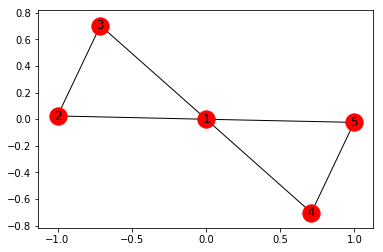

In [186]:
G1 = {1:{2,3,4,5}, 2:{1,3}, 3:{1,2}, 4: {1,5}, 5:{1,4}}
draw_graph(G1)

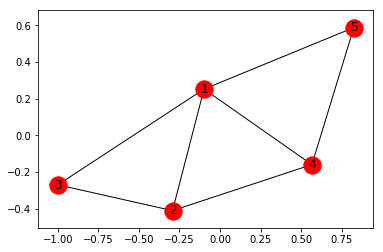

In [189]:
G2 = {1:{2,3,4,5}, 2:{1,3,4}, 3:{1,2}, 4: {1,2,5}, 5:{1,4}}
draw_graph(G2)

In [173]:
lp_entropy(G1)

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]] (470, 31)
(1,) 1.0
(1, 2) 2.0000000000000004
(1, 2, 3) 2.000000000000002
(1, 2, 3, 4) 2.999999999999991
(1, 2, 3, 4, 5) 2.9999999999999982
(1, 2, 3, 5) 2.9999999999999916
(1, 2, 4) 2.9999999999999902
(1, 2, 4, 5) 3.0000000000000036
(1, 2, 5) 2.9999999999999973
(1, 3) 2.0000000000000093
(1, 3, 4) 2.999999999999992
(1, 3, 4, 5) 2.999999999999993
(1, 3, 5) 2.9999999999999925
(1, 4) 2.0000000000000053
(1, 4, 5) 2.0000000000000053
(1, 5) 2.000000000000004
(2,) 0.9999999999999999
(2, 3) 1.9999999999999922
(2, 3, 4) 2.999999999999988
(2, 3, 4, 5) 2.9999999999999982
(2, 3, 5) 2.99999999999999
(2, 4) 2.000000000000003
(2, 4, 5) 2.0000000000000084
(2, 5) 1.9999999999999982
(3,) 0.9999999999999999
(3, 4) 2.0000000000000004
(3, 4, 5) 2.000000000000004
(3, 5) 1.9999999999999944
(4,) 1.0
(4, 5) 1.00000000000001

     con: array([ 0.00000000e+00,  7.10542736e-15, -1.77635684e-15, -1.33226763e-15,
        0.00000000e+00])
     fun: -2.9999999999999982
 message: 'Optimization terminated successfully.'
     nit: 861
   slack: array([ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
       -4.44089210e-16,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.28785871e-14,  4.88498131e-15,  8.88178420e-16,
       -9.32587341e-15,  8.43769499e-15,  1.11022302e-14,  1.99840144e-15,
       -5.32907052e-15,  1.37667655e-14, -3.55271368e-15,  1.77635684e-15,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e

In [174]:
lp_entropy(G2)

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]] (470, 31)
(1,) 0.9999999999999998
(1, 2) 1.9999999999999891
(1, 2, 3) 1.9999999999999978
(1, 2, 3, 4) 2.999999999999993
(1, 2, 3, 4, 5) 2.9999999999999933
(1, 2, 3, 5) 2.999999999999994
(1, 2, 4) 2.999999999999994
(1, 2, 4, 5) 2.9999999999999827
(1, 2, 5) 2.999999999999996
(1, 3) 1.9999999999999882
(1, 3, 4) 2.9999999999999907
(1, 3, 4, 5) 2.99999999999999
(1, 3, 5) 2.9999999999999822
(1, 4) 1.9999999999999953
(1, 4, 5) 1.999999999999999
(1, 5) 1.9999999999999873
(2,) 1.0
(2, 3) 1.999999999999994
(2, 3, 4) 2.9999999999999893
(2, 3, 4, 5) 2.9999999999999933
(2, 3, 5) 2.9999999999999876
(2, 4) 2.0000000000000004
(2, 4, 5) 2.0000000000000067
(2, 5) 2.000000000000002
(3,) 0.9999999999999999
(3, 4) 1.9999999999999971
(3, 4, 5) 2.000000000000001
(3, 5) 1.9999999999999962
(4,) 0.9999999999999998
(4, 5) 1

     con: array([ 0.00000000e+00, -2.22044605e-15, -8.65973959e-15,  1.33226763e-14,
       -3.55271368e-15])
     fun: -2.9999999999999933
 message: 'Optimization terminated successfully.'
     nit: 830
   slack: array([ 2.22044605e-16,  1.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.06581410e-14,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  6.21724894e-15,  2.37587727e-14,  5.99520433e-15,
        1.13242749e-14,  6.21724894e-15,  1.08801856e-14,  1.37667655e-14,
        4.21884749e-15,  4.66293670e-15,  1.08801856e-14,  8.65973959e-15,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e

In [175]:
check_identical_entropy(G1,G2)

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]] (470, 31)
(1,) 1.0
(1, 2) 2.0000000000000004
(1, 2, 3) 2.000000000000002
(1, 2, 3, 4) 2.999999999999991
(1, 2, 3, 4, 5) 2.9999999999999982
(1, 2, 3, 5) 2.9999999999999916
(1, 2, 4) 2.9999999999999902
(1, 2, 4, 5) 3.0000000000000036
(1, 2, 5) 2.9999999999999973
(1, 3) 2.0000000000000093
(1, 3, 4) 2.999999999999992
(1, 3, 4, 5) 2.999999999999993
(1, 3, 5) 2.9999999999999925
(1, 4) 2.0000000000000053
(1, 4, 5) 2.0000000000000053
(1, 5) 2.000000000000004
(2,) 0.9999999999999999
(2, 3) 1.9999999999999922
(2, 3, 4) 2.999999999999988
(2, 3, 4, 5) 2.9999999999999982
(2, 3, 5) 2.99999999999999
(2, 4) 2.000000000000003
(2, 4, 5) 2.0000000000000084
(2, 5) 1.9999999999999982
(3,) 0.9999999999999999
(3, 4) 2.0000000000000004
(3, 4, 5) 2.000000000000004
(3, 5) 1.9999999999999944
(4,) 1.0
(4, 5) 1.00000000000001

True